In [6]:
!pip install tiktoken

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 20.0 MB/s eta 0:00:00


In [7]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import tiktoken

from utilities.gpt_module import GPTModel
import importlib
from utilities import supporting_modules
from utilities.supporting_modules import create_dataloader, GPTDataset


In [8]:
gpt_config_124m = {
"vocab_size": 50257,
"context_length": 256, #A
"emb_dim": 768,
"n_heads": 12,
"n_layers": 12,
"drop_rate": 0.1, #B
"qkv_bias": False
}

##### Text generation Helping functions
A three-step text generation process using a GPT model:
- First, the tokenizer converts input text into a series of token IDs,
- Second, the model receives these token IDs and generates corresponding logits, which are vectors representing the probability distribution for each token in the vocabulary.
- Third, these logits are converted back into token IDs, which the tokenizer decodes into human-readable text, completing the cycle from textual input to textual output.

In [3]:
def generate_text(model, ids, max_new_tokens, context_size):
    for _ in range(max_new_tokens):
        ids_cond = ids[:, -context_size:]
        with torch.no_grad():
            logits = model(ids_cond)
        logits_new_token = logits[:, -1, :]
        probas = torch.softmax(logits_new_token, dim=-1)
        ids_next = torch.argmax(probas, dim=-1, keepdim=True) # index of highest probability in probas tensor is actually the id for next token
        ids = torch.cat((ids, ids_next), dim=1) # concatenate new token id with previous ids to generate full text
    return ids


def text_to_token_ids(text, tokenizer):
    encoded = tokenizer.encode(text, allowed_special={'<|endoftext|>'})
    encoded_tensor = torch.tensor(encoded).unsqueeze(0)
    return encoded_tensor

def token_ids_to_text(token_ids, tokenizer):
    flat = token_ids.squeeze(0) # to remove batch dimension
    return tokenizer.decode(flat.tolist())

### Setting the data

In [9]:
# file_path = "data/the_verdict.txt"
file_path = "data/novel.txt"
with open(file_path, "r", encoding="utf-8") as file:
    text_data = file.read()
train_ratio = 0.90
split_idx = int(train_ratio * len(text_data))
train_data = text_data[:split_idx]
val_data = text_data[split_idx:]

# crafting data loaders
train_loader = create_dataloader(
train_data,
batch_size=2,
max_length=gpt_config_124m["context_length"],
stride=gpt_config_124m["context_length"],
drop_last=True,
shuffle=True
)
val_loader = create_dataloader(
val_data,
batch_size=2,
max_length=gpt_config_124m["context_length"],
stride=gpt_config_124m["context_length"],
drop_last=False,
shuffle=False
)

## Training Function

In [14]:
def cross_entropy_batch_loss(input_batch, target_batch, model, device):
    input_batch, target_batch = input_batch.to(device), target_batch.to(device)
    logits = model(input_batch)
    loss = torch.nn.functional.cross_entropy(logits.flatten(0, 1), target_batch.flatten())
    return loss

def loss_calculator(data_loader, model, loss_function, device, num_batches=None):
    total_loss = 0.
    if num_batches is None:
        num_batches = len(data_loader) # A
    else:
        num_batches = min(num_batches, len(data_loader)) # B
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            loss = loss_function(input_batch, target_batch, model, device)
            total_loss += loss
            break
        else:
            break
    return total_loss / num_batches

In [21]:
def generate_and_print_sample(model, tokenizer, device, start_context):
    model.eval()
    context_size = model.pos_emb.weight.shape[0]
    encoded = text_to_token_ids(start_context, tokenizer).to(device)
    with torch.no_grad():
        token_ids = generate_text(model=model, ids=encoded,
        max_new_tokens=50, context_size=context_size)
        decoded_text = token_ids_to_text(token_ids, tokenizer)
        print(decoded_text.replace("\n", " ")) # Compact print format
    model.train()


def evaluate_model(model, train_loader, val_loader, device, eval_iter):
    model.eval() #A
    with torch.no_grad(): #B
        train_loss = loss_calculator(train_loader, model,cross_entropy_batch_loss, device, num_batches=eval_iter)
        val_loss = loss_calculator(val_loader, model, cross_entropy_batch_loss, device, num_batches=eval_iter)
    model.train()
    return train_loss, val_loss


In [22]:
device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
def train_model(model, train_loader, val_loader, optimizer, device,
               eval_freq, eval_iter, num_epochs, start_context):
    train_losses, val_losses, track_token_seens = [],[], []
    tokens_seen, global_step = 0,-1
    for epoch in range(num_epochs):
        model.train()
        for input_batch, target_batch in train_loader:
            optimizer.zero_grad()
            loss = loss_calculator(train_loader, model, cross_entropy_batch_loss, device)
            loss.backward()
            optimizer.step()

            tokens_seen +=input_batch.numel()
            global_step+=1
            if global_step%eval_freq==0:
                train_loss, val_loss = evaluate_model(model, train_loader, val_loader, device, eval_iter)
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                track_token_seens.append(tokens_seen)
                print(f"Epoch: {epoch+1} (Step: {global_step: 06d}):",
                     f"Train loss: {train_loss: .3f}, Val loss: {val_loss: .3f}")
            generate_and_print_sample( model, train_loader.dataset.tokenizer, device, start_context)
    return train_losses, val_losses, track_token_seens


In [ ]:
del train_losses, val_losses, tokens_seen
torch.cuda.empty_cache()

In [32]:
torch.manual_seed(123)
# del train_losses, val_losses, tokens_seen
torch.cuda.empty_cache()


model = GPTModel(gpt_config_124m)
model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0004, weight_decay=0)


# num_epochs = 10
train_losses, val_losses, tokens_seen = train_model(model, train_loader, val_loader,
                                                    optimizer, device,
                                                    eval_freq=1, eval_iter=1,
                                                    num_epochs=4,
                                                    start_context="One of the most remarkable")


Epoch: 1 (Step:  00000): Train loss:  9.836, Val loss:  9.893
One of the most remarkable                                                  
Epoch: 1 (Step:  00001): Train loss:  9.407, Val loss:  9.451
One of the most remarkable                                                  
Epoch: 1 (Step:  00002): Train loss:  9.294, Val loss:  9.141
One of the most remarkable                                                  
Epoch: 1 (Step:  00003): Train loss:  8.871, Val loss:  8.909
One of the most remarkable                                                  
Epoch: 1 (Step:  00004): Train loss:  8.890, Val loss:  8.704
One of the most remarkable                                                  
Epoch: 1 (Step:  00005): Train loss:  8.279, Val loss:  8.499
One of the most remarkable                                                  
Epoch: 1 (Step:  00006): Train loss:  8.474, Val loss:  8.322
One of the most remarkable                                                  
Epoch: 1 (Step:  00007): Tr

In [33]:
# Save model and optimizer parameters:
torch.save({
"model_state_dict": model.state_dict(),
"optimizer_state_dict": optimizer.state_dict(),
},
"/content/drive/MyDrive/model_params/llm_gpt2_model_and_optimizer.pth"
)

In [35]:
train_losses_numpy = np.array([loss.cpu().numpy() for loss in train_losses])
val_losses_numpy = np.array([loss.cpu().numpy() for loss in val_losses])

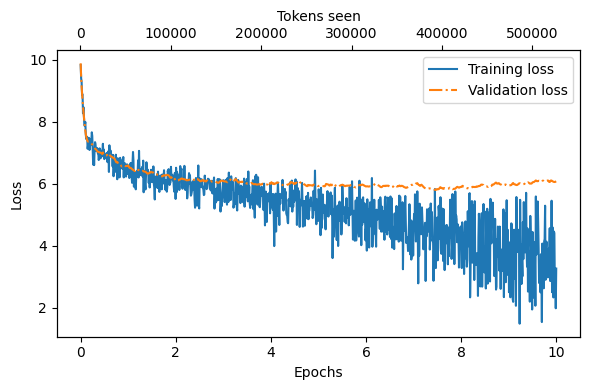

In [37]:
import matplotlib.pyplot as plt
def plot_losses(epochs_seen, tokens_seen, train_losses, val_losses):
  fig, ax1 = plt.subplots(figsize=(6, 4))
  ax1.plot(epochs_seen, train_losses, label="Training loss")
  ax1.plot(epochs_seen, val_losses, linestyle="-.", label="Validation loss")
  ax1.set_xlabel("Epochs")
  ax1.set_ylabel("Loss")
  ax1.legend(loc="upper right")
  ax2 = ax1.twiny() #A
  ax2.plot(tokens_seen, train_losses, alpha=0) #B
  ax2.set_xlabel("Tokens seen")
  fig.tight_layout()
  plt.show()

epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
plot_losses(epochs_tensor, tokens_seen, train_losses_numpy, val_losses_numpy)

# Text Generation Strategies to Reduce Training Data Memorizaiton
The model memorizes the training data verbatim by searching for
the generated text snippets because of very small training data. We employ some text generation strategies to generate more diverse output texts.

In [44]:
# Revisiting the generate_text() function
model.to('cpu')
model.eval()

tokenizer = tiktoken.get_encoding("gpt2")
ids = text_to_token_ids("Every effort moves you", tokenizer)
context_size=gpt_config_124m["context_length"]
next_text_ids=generate_text(model, ids, max_new_tokens=25, context_size=context_size)
new_text = token_ids_to_text(next_text_ids, tokenizer)
print(new_text)

Every effort moves you that it, and
to the _The
_ of the same
of material. The "the _Pamela


The generated token is selected at each
generation step corresponding to the largest probability score among all
tokens in the vocabulary. We implement following two techniques to control the rondomness and diversity of the generted text:
- Temperature Scalling
- Top-k samping

These techniques will be explained in a separate notebook. Here we just implement these techniques.

#### Temperature scalling
Previously, we sampled the token with the highest probability as the next token using `torch.argmax`. To generate text with more variety, we can replace the argmax with a function that samples from a probability
distribution (here, the probability scores the LLM generates for each
vocabulary entry at each token generation step)

In [48]:
# to implement temperature scaling, we modify the generate_text() function as follows:
def generate_text(model, idx, max_new_tokens, context_size, temperature, top_k=None):
    for _ in range(max_new_tokens): #A
        idx_cond = idx[:, -context_size:]
        with torch.no_grad():
          logits = model(idx_cond)
        logits = logits[:, -1, :]
        if top_k is not None: #B
          top_logits, _ = torch.topk(logits, top_k)
          min_val = top_logits[:, -1]
          logits = torch.where(
          logits < min_val,
          torch.tensor(float('-inf')).to(logits.device),
          logits
          )
        if temperature > 0.0: #C
          logits = logits / temperature
          probs = torch.softmax(logits, dim=-1)
          idx_next = torch.multinomial(probs, num_samples=1)
        else: #D
          idx_next = torch.argmax(logits, dim=-1, keepdim=True)
        idx = torch.cat((idx, idx_next), dim=1)
    return idx

In [51]:
torch.manual_seed(123)
token_ids = generate_text(
model=model,
idx=text_to_token_ids("Every effort moves you", tokenizer),
max_new_tokens=15,
context_size=gpt_config_124m["context_length"],
top_k=25,
temperature=1.4
)
token_ids_to_text(token_ids, tokenizer)

'Every effort moves you have passed a novelist or twiceianation it was of\nfaith upon not'

We can see quality of text has improved by implementing temperature scaling and top-k sampling.